In [28]:
#preprocessing data test

In [43]:
!python2 preprocess.py test.csv

Processing 300000/300000
Saved processed tweets to: test-processed.csv


In [44]:
#preprocessing data train

In [45]:
!python2 preprocess.py train-processed.csv

Processing 100000/100000
Saved processed tweets to: train-processed-processed.csv


In [ ]:
#show statistic data train have preprocessed

In [46]:
!python2 stats.py train-processed.csv

Processing 100000/100000
Calculating frequency distribution
Saved uni-frequency distribution to train-processed-freqdist.pkl
Saved bi-frequency distribution to train-processed-freqdist-bi.pkl

[Analysis Statistics]
Tweets => Total: 100000, Positive: 56462, Negative: 43538
User Mentions => Total: 88958, Avg: 0.8896, Max: 12
URLs => Total: 3602, Avg: 0.0360, Max: 4
Emojis => Total: 633, Positive: 442, Negative: 191, Avg: 0.0063, Max: 3
Words => Total: 1190790, Unique: 50335, Avg: 11.9079, Max: 40, Min: 0
Bigrams => Total: 1091450, Unique: 384499, Avg: 10.9145


In [ ]:
#show prediction accuracy Model Machine Learning

In [47]:
!python2 models/baseline.py  TRAIN = True

Correct = 65.32%


In [48]:
!python2 models/randomforest.py  TRAIN = True

Generating feature vectors
Processing 100000/100000

Extracting features & training batches
Processing 1/1/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Testing
Processing 1/1
Correct: 7163/10000 = 71.6300 %


In [49]:
!python2 models/naivebayes.py  TRAIN = True

Generating feature vectors
Processing 100000/100000

Extracting features & training batches
Processing 1/1

Testing
Processing 1/1
Correct: 7680/10000 = 76.8000 %


In [50]:
!python2 models/decisiontree.py  TRAIN = True

Generating feature vectors
Processing 100000/100000

Extracting features & training batches
Processing 1/1

Testing
Processing 1/1
Correct: 6823/10000 = 68.2300 %


In [51]:
!python2 models/svm.py  TRAIN = True

Generating feature vectors
Processing 100000/100000

Extracting features & training batches
Processing 1/1

Testing
Processing 1/1
Correct: 7831/10000 = 78.3100 %


In [58]:
import utils
import random
import numpy as np
from xgboost import XGBClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using XGBoost.


FREQ_DIST_FILE = '/content/train-processed-freqdist.pkl'
BI_FREQ_DIST_FILE = '/content/train-processed-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = '/content/train-processed.csv'
TEST_PROCESSED_FILE = '/content/test-processed.csv'
TRAIN = True
UNIGRAM_SIZE = 1500
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 100
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in range(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)
    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file
    Returns:
        list: Of tuples
    """
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            utils.write_status(i + 1, total)
    print ('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(20)
    unigrams = utils.top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = utils.top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = utils.split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    clf = XGBClassifier(max_depth=25, silent=False, n_estimators=20)
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        utils.write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.fit(training_set_X, training_set_y)
    print ('\n')
    print ('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            utils.write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print ('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            utils.write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        utils.save_results_to_csv(predictions, 'xgboost.csv')
        print ('\nSaved to xgboost.csv')


Generating feature vectors
Processing 100000/100000

Extracting features & training batches
Processing 1/1

Testing
Processing 1/1
Correct: 7141/10000 = 71.4100 %


In [65]:
!python models/neuralnet.py

Generating feature vectors
Processing 100000/100000

Extracting features & training batches
2022-01-21 09:18:22.877911: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Iteration 180/180, loss:0.5590, acc:0.7120
Epoch: 1, val_acc:0.7298
Accuracy improved from 0.0000 to 0.7298, saving model
Iteration 180/180, loss:0.5200, acc:0.7500
Epoch: 2, val_acc:0.7609
Accuracy improved from 0.7298 to 0.7609, saving model
Testing
Generating feature vectors
Processing 300000/300000

Predicting batches
Processing 600/600
Saved to 1layerneuralnet.csv


In [ ]:
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################

############################################################# installing glove-twitter-word-vocabolary ################################################################################

In [66]:
!wget http://nlp.stanford.edu/data/glove.6B.zip 


--2022-01-21 09:21:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-21 09:21:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-21 09:21:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [67]:
!unzip /content/dataset/glove*.zip


Archive:  /content/dataset/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################

############################################################# DEEP LEARNING CNN AND LSTM FOR NLP  ################################################################################

In [84]:
!python models/cnn.py

Looking for GLOVE seeds
Processing 400000/0

Generating feature vectors
Processing 100000/100000

2022-01-21 09:47:00.454780: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Epoch 1/5
200/200 [==============================] - 228s 1s/step - loss: 0.6253 - accuracy: 0.6382 - val_loss: 0.5169 - val_accuracy: 0.7446
Epoch 2/5
200/200 [==============================] - 242s 1s/step - loss: 0.5254 - accuracy: 0.7352 - val_loss: 0.4912 - val_accuracy: 0.7649
Epoch 3/5
200/200 [==============================] - 236s 1s/step - loss: 0.4986 - accuracy: 0.7541 - val_loss: 0.4733 - val_accuracy: 0.7724
Epoch 4/5
200/200 [==============================] - 225s 1s/step - loss: 0.4724 - accuracy: 0.7736 - val_loss: 0.4726 - val_accuracy: 0.7748
Epoch 5/5
200/200 [==============================] - 222s 1s/step - loss: 0.4525 - accuracy: 0.7851 - val_loss: 0.4633 - val_accuracy: 0.7778


In [ ]:
#diatas CNN dengan 5 epochs, 704 steps per epoch.

In [72]:
!python models/lstm.py

Correct = 65.32%


In [73]:
#diatas dengan 3 epochs dan 200 steps per epochs

In [ ]:
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################
#################################################  #################################################

############################################################# PLOTING INFORMATION REPORT ################################################################################

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import utils
import pickle
%matplotlib inline  

In [75]:
FREQ_DIST_FILE = '/content/train-processed-freqdist.pkl'
BI_FREQ_DIST_FILE = '/content/train-processed-freqdist-bi.pkl'

In [77]:
with open(FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
unigrams = freq_dist.most_common(20)
unigrams

[('i', 50024),
 ('the', 29724),
 ('to', 29521),
 ('you', 26859),
 ('a', 22040),
 ('it', 17428),
 ('and', 16325),
 ('my', 13758),
 ('for', 12530),
 ('is', 12029),
 ('in', 11793),
 ('that', 11399),
 ('im', 11182),
 ('me', 10972),
 ('of', 10585),
 ('have', 9950),
 ('on', 9612),
 ('so', 9132),
 ('but', 9018),
 ('be', 7431)]

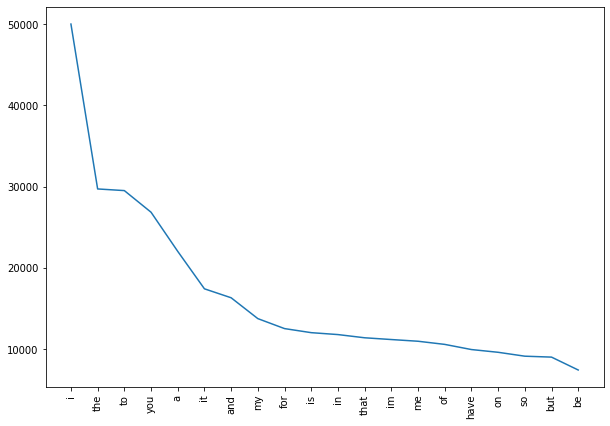

In [78]:
plt.figure(1, [10, 7])
x = np.array(range(0, 40, 2))
y = np.array([i[1] for i in unigrams])
my_xticks = [i[0] for i in unigrams]
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)
plt.show()

In [79]:
with open(BI_FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
bigrams = freq_dist.most_common(20)
bigrams

[(('i', 'have'), 2442),
 (('in', 'the'), 2371),
 (('i', 'was'), 2271),
 (('for', 'the'), 2163),
 (('i', 'dont'), 2073),
 (('i', 'am'), 2047),
 (('have', 'a'), 1923),
 (('but', 'i'), 1902),
 (('i', 'love'), 1876),
 (('i', 'know'), 1871),
 (('on', 'the'), 1742),
 (('to', 'be'), 1693),
 (('have', 'to'), 1684),
 (('i', 'think'), 1682),
 (('and', 'i'), 1615),
 (('i', 'cant'), 1587),
 (('going', 'to'), 1585),
 (('it', 'was'), 1535),
 (('of', 'the'), 1455),
 (('thanks', 'for'), 1379)]

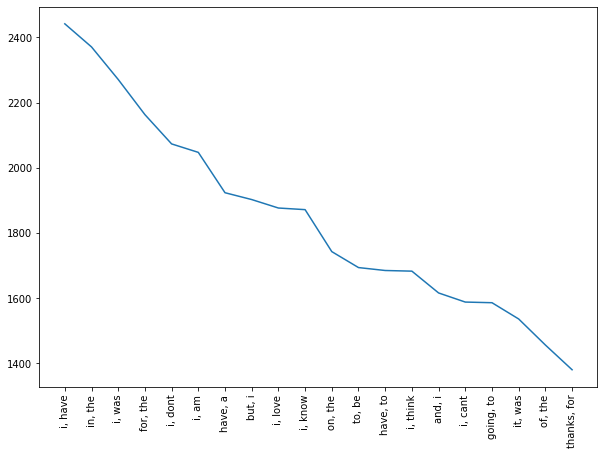

In [80]:
plt.figure(1, [10, 7])
x = np.array(range(0, 40, 2))
y = np.array([i[1] for i in bigrams])
my_xticks = [', '.join(i[0]) for i in bigrams]
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)
plt.show()

In [81]:
with open(FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
unigrams = freq_dist.most_common(100)
log_ranks = np.log(range(1, 101))
log_freqs = np.log([i[1] for i in unigrams])
z = np.polyfit(log_ranks, log_freqs, 1)
p = np.poly1d(z)
p

poly1d([-0.76603161, 11.18429205])

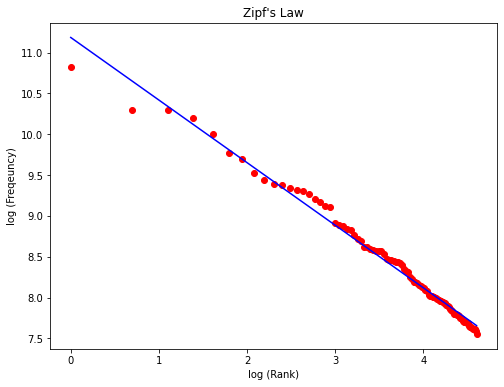

In [82]:
plt.figure(3, [8,6])
plt.plot(log_ranks, log_freqs, 'ro')
plt.plot(log_ranks,p(log_ranks),'b-')
plt.xlabel('log (Rank)')
plt.ylabel('log (Freqeuncy)')
plt.title('Zipf\'s Law')
plt.show()

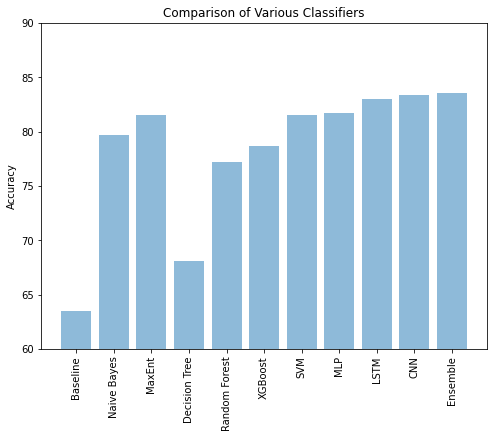

In [83]:
classifiers = ['Baseline', 'Naive Bayes', 'MaxEnt', 'Decision Tree', 'Random Forest', 'XGBoost', 'SVM', 'MLP', 'LSTM', 'CNN', 'Ensemble']
accuracies = [63.48, 79.68, 81.52, 68.1, 77.21, 78.72, 81.55, 81.7, 83.00, 83.34, 83.58]
plt.figure(4, [8,6])
plt.bar(range(len(classifiers)), accuracies, align='center', alpha=0.5)
plt.xticks(range(len(classifiers)), classifiers, rotation=90)
plt.ylabel('Accuracy')
plt.title('Comparison of Various Classifiers')
plt.ylim([60, 90])
plt.show()